In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [9]:
# utility function to calculate mean squared error
def mse(original, pred):
    print(pred)
    error = 0
    for i in range(len(original)):
        subbed = np.subtract(original[i], pred[i])
        error += np.dot(subbed, subbed)
    return error / len(original)

In [10]:
x_train = pd.read_csv("data/data_train.csv")
x_train = x_train.dropna(axis=1)
y_train = x_train[["emotion"]].copy()
x_train = np.array(x_train.drop(["emotion", "Usage"], axis=1))

x_test = pd.read_csv("data/data_test.csv")
x_test = x_test.dropna(axis=1)
y_test = x_test[["emotion"]].copy()
x_test = np.array(x_test.drop(["emotion", "Usage"], axis=1))

In [11]:
x_train = x_train.reshape((len(x_train), 48, 48, 1))
x_test = x_test.reshape((len(x_test), 48, 48, 1))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(719, 48, 48, 1) (81, 48, 48, 1)
(719, 7) (81, 7)


In [13]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [39]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(x_train)

In [40]:
def build_net(optim):
    img_width = 48
    img_height = 48
    img_depth = 1
    num_classes = 7
    
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [41]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [42]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[0]) 


Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

In [43]:
history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
#     use_multiprocessing=True
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 22.46875 steps, validate on 81 samples
Epoch 1/100
23/22 [==============================] - 44s 2s/step - loss: 3.0021 - accuracy: 0.2156 - val_loss: 19.7646 - val_accuracy: 0.2963
Epoch 2/100
23/22 [==============================] - 38s 2s/step - loss: 2.2543 - accuracy: 0.3352 - val_loss: 5.1838 - val_accuracy: 0.3210
Epoch 3/100
23/22 [==============================] - 32s 1s/step - loss: 1.9501 - accuracy: 0.4047 - val_loss: 2.0386 - val_accuracy: 0.4938
Epoch 4/100
23/22 [==============================] - 32s 1s/step - loss: 1.6376 - accuracy: 0.4673 - val_loss: 1.4325 - val_accuracy: 0.5802
Epoch 5/100
23/22 [==============================] - 36s 2s/step - loss: 1.4653 - accuracy: 0.5035 - val_loss: 1.6322 - val_accuracy: 0.5802
Epoch 6/100
23/22 [==============================] - 42s 2s/step - loss: 1.3179 - accuracy: 0.5591 - val_loss: 3.0558 - val_accuracy: 0.4444
Epo

23/22 [==============================] - 43s 2s/step - loss: 0.2812 - accuracy: 0.8999 - val_loss: 0.1218 - val_accuracy: 0.9506
Epoch 52/100
23/22 [==============================] - 42s 2s/step - loss: 0.3105 - accuracy: 0.8929 - val_loss: 0.1476 - val_accuracy: 0.9383
Epoch 53/100
23/22 [==============================] - 42s 2s/step - loss: 0.3269 - accuracy: 0.8832 - val_loss: 0.1585 - val_accuracy: 0.9383
Epoch 54/100
23/22 [==============================] - 42s 2s/step - loss: 0.3122 - accuracy: 0.8901 - val_loss: 0.1533 - val_accuracy: 0.9506
Epoch 55/100
23/22 [==============================] - 42s 2s/step - loss: 0.2569 - accuracy: 0.9166 - val_loss: 0.1353 - val_accuracy: 0.9383
Epoch 56/100
22/22 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.9112
Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
23/22 [==============================] - 42s 2s/step - loss: 0.2662 - accuracy: 0.9110 - val_loss: 0.1616 - val_accuracy: 0.938

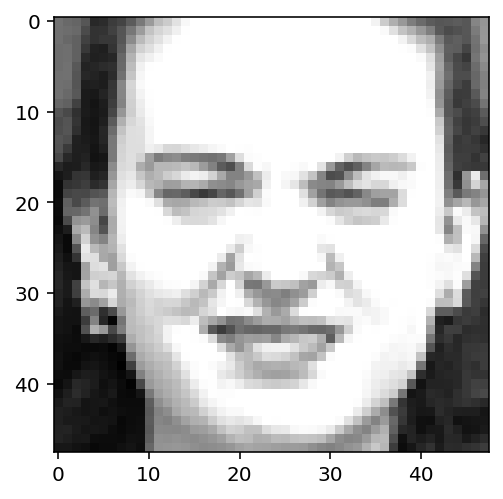

true val: disgusted , prediction: disgusted


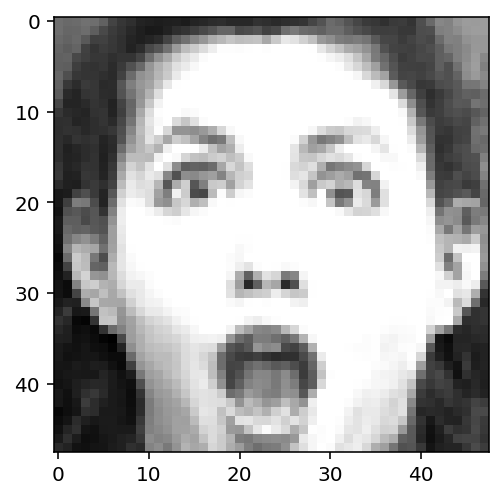

true val: surprised , prediction: surprised


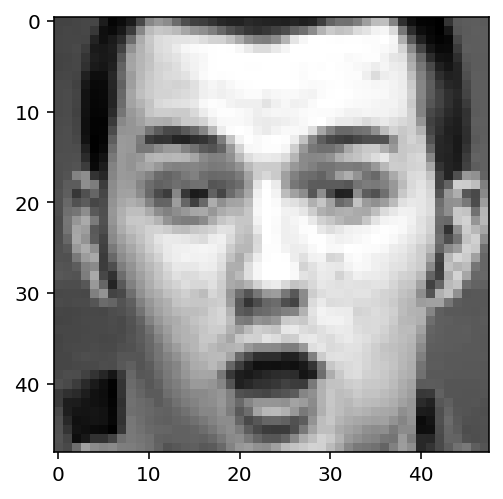

true val: surprised , prediction: surprised


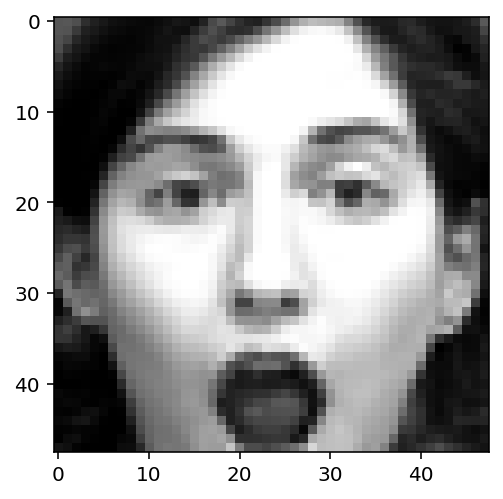

true val: surprised , prediction: surprised


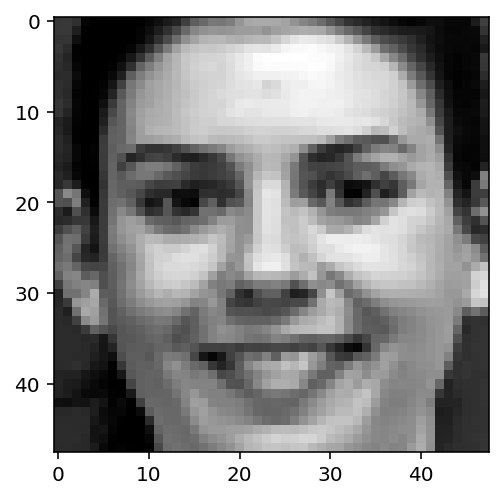

true val: happy , prediction: happy


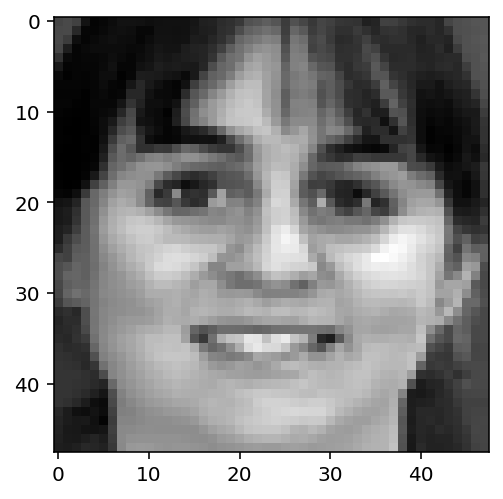

true val: happy , prediction: happy


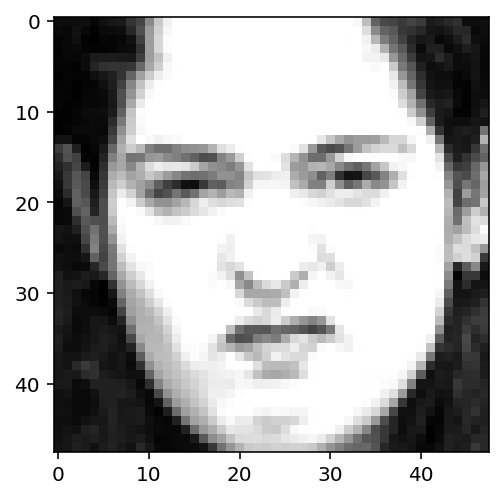

true val: disgusted , prediction: disgusted


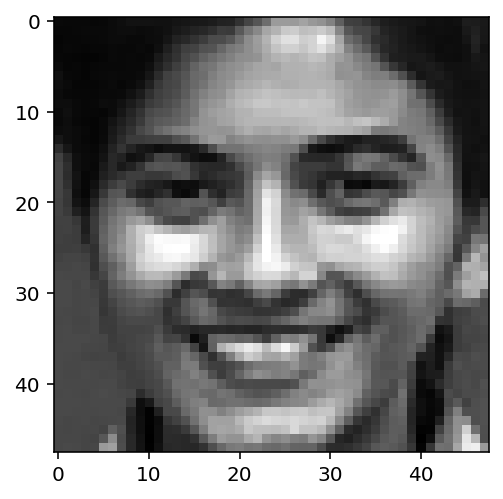

true val: happy , prediction: happy


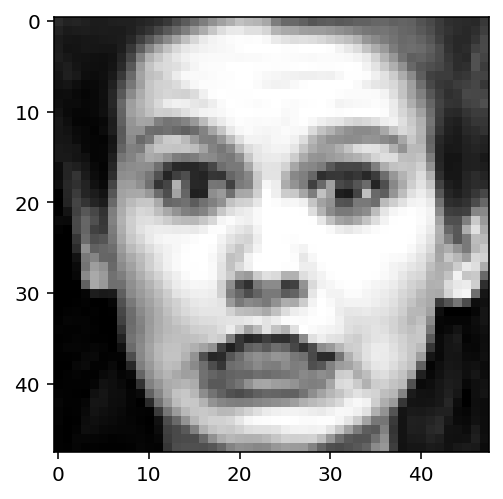

true val: afraid , prediction: afraid


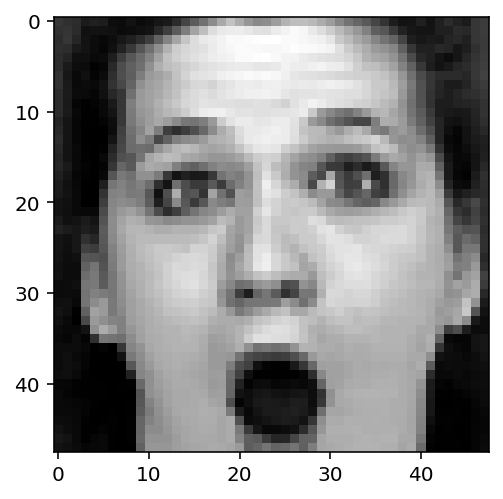

true val: surprised , prediction: surprised


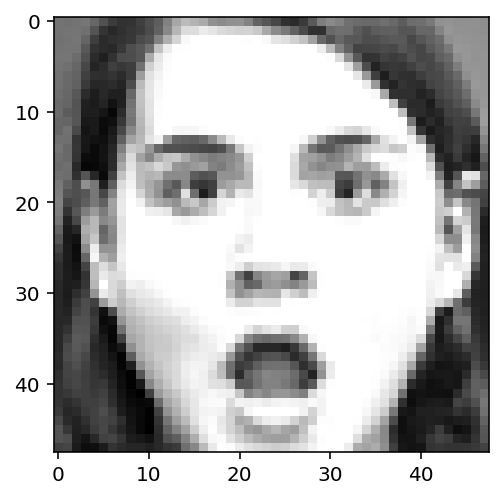

true val: surprised , prediction: surprised


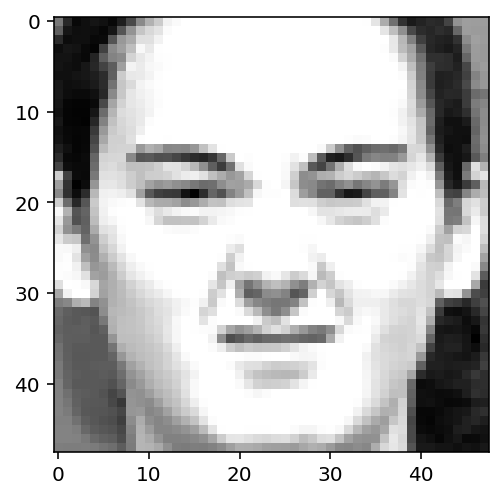

true val: disgusted , prediction: disgusted


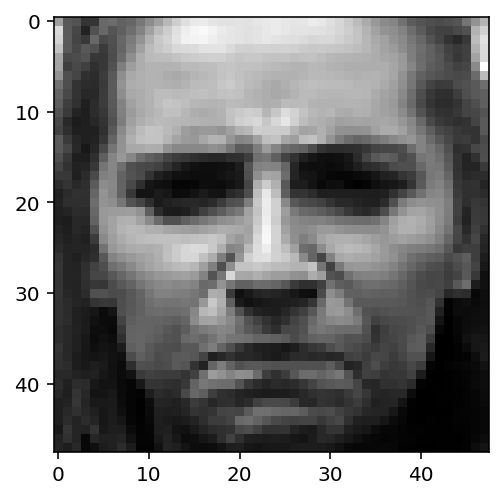

true val: angry , prediction: angry


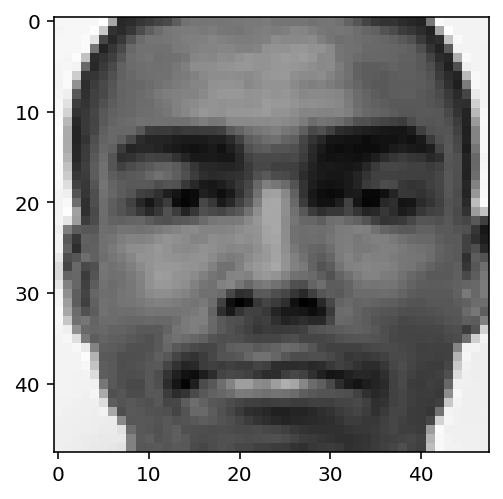

true val: neutral , prediction: neutral


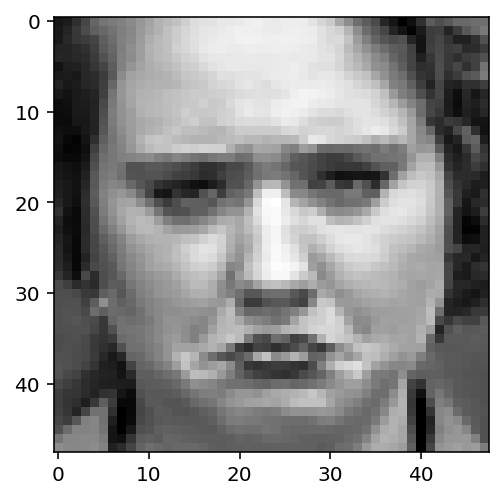

true val: sad , prediction: sad


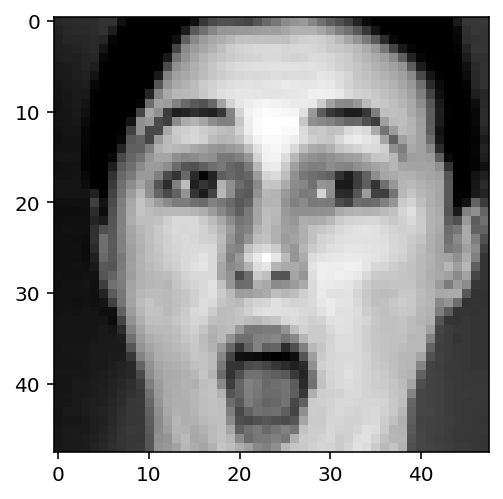

true val: surprised , prediction: surprised


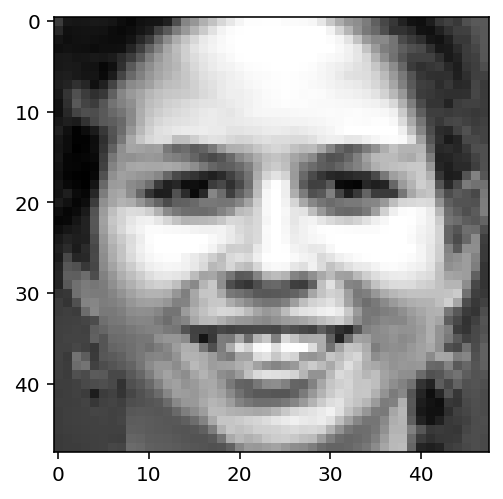

true val: happy , prediction: happy


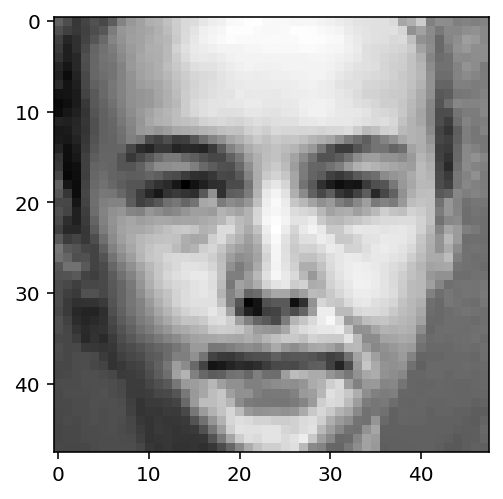

true val: neutral , prediction: neutral


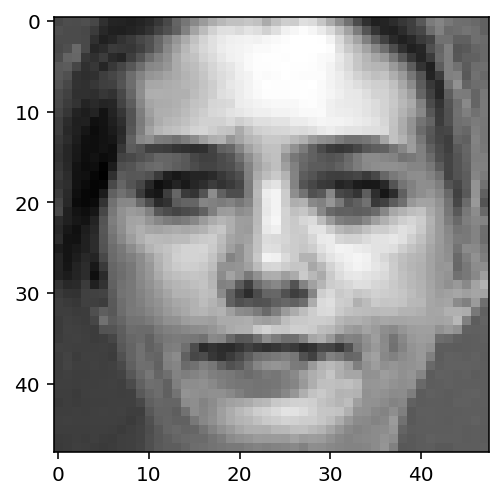

true val: neutral , prediction: neutral


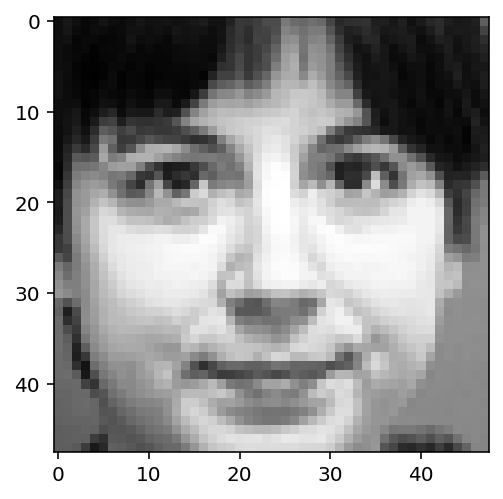

true val: neutral , prediction: neutral


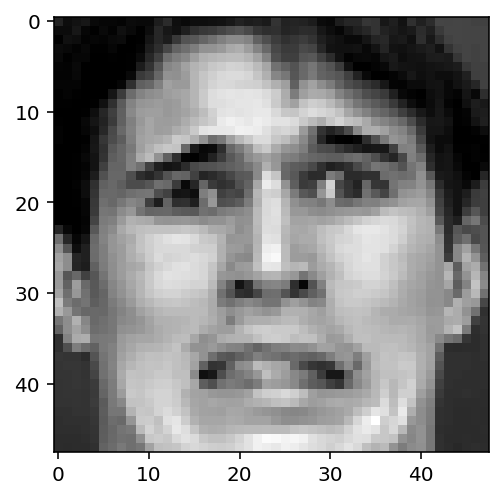

true val: afraid , prediction: afraid


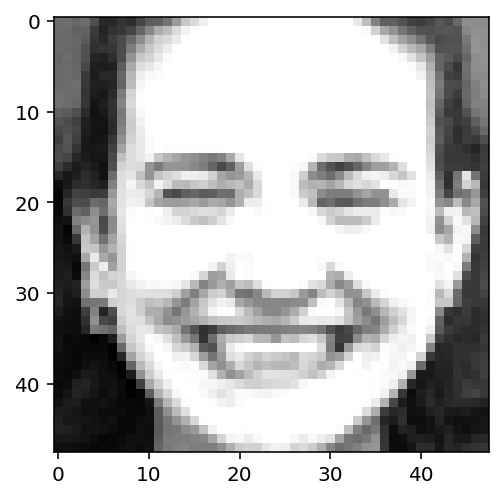

true val: happy , prediction: happy


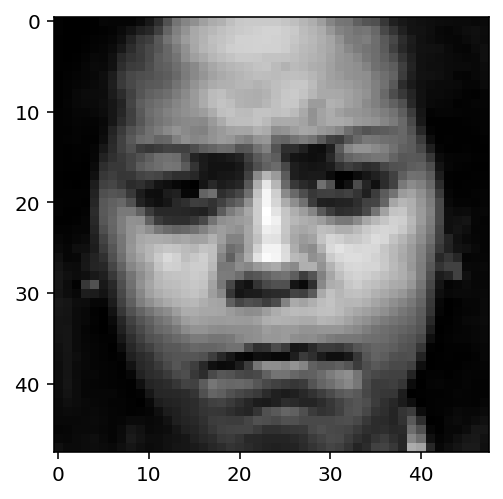

true val: angry , prediction: angry


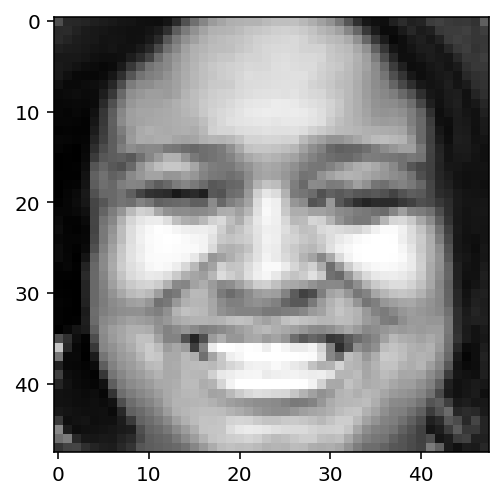

true val: happy , prediction: happy


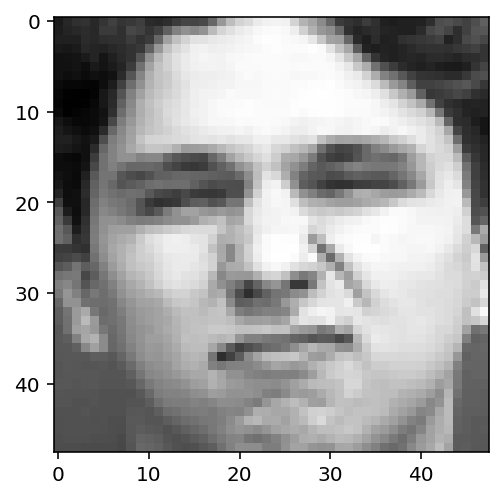

true val: disgusted , prediction: disgusted


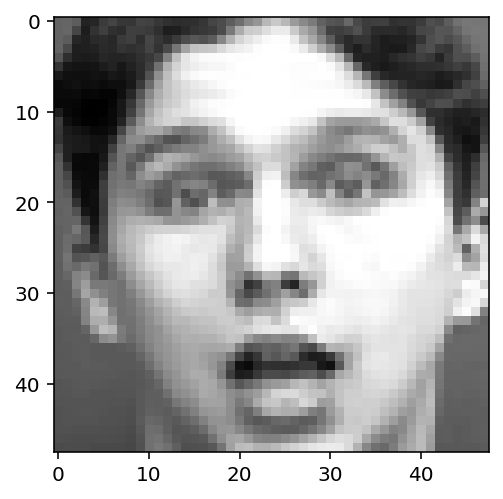

true val: surprised , prediction: surprised


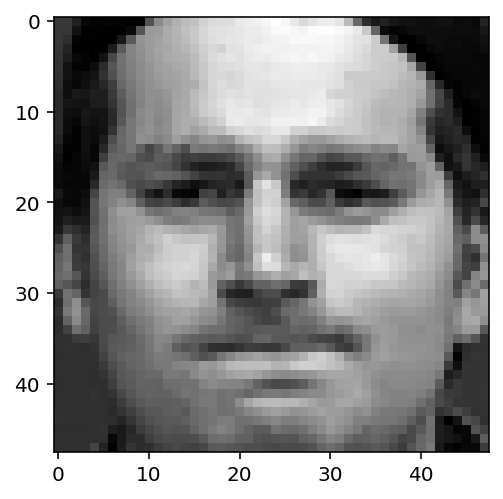

true val: angry , prediction: angry


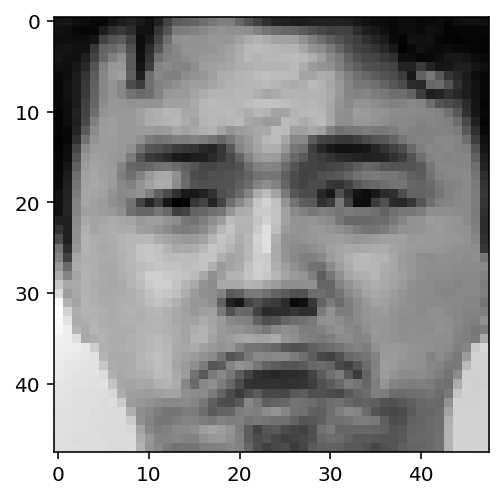

true val: sad , prediction: sad


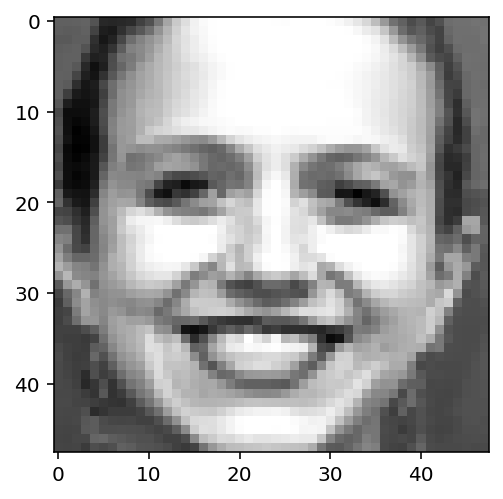

true val: happy , prediction: happy


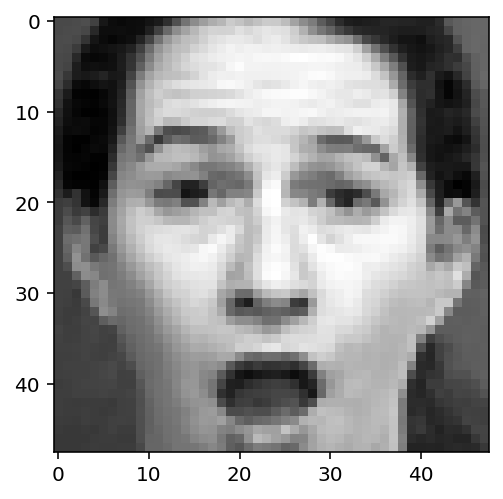

true val: surprised , prediction: surprised


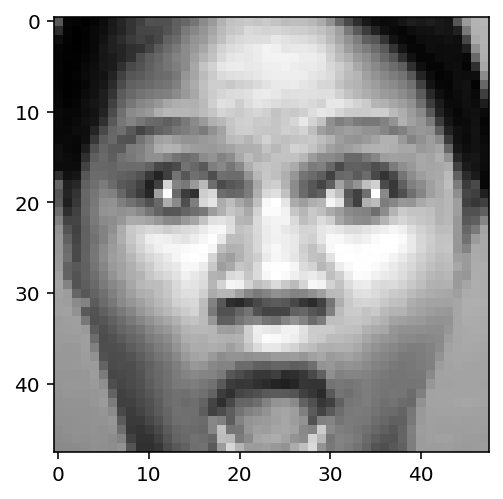

true val: surprised , prediction: surprised


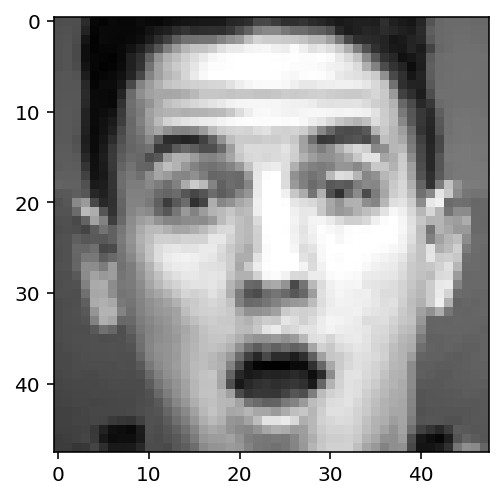

true val: surprised , prediction: surprised


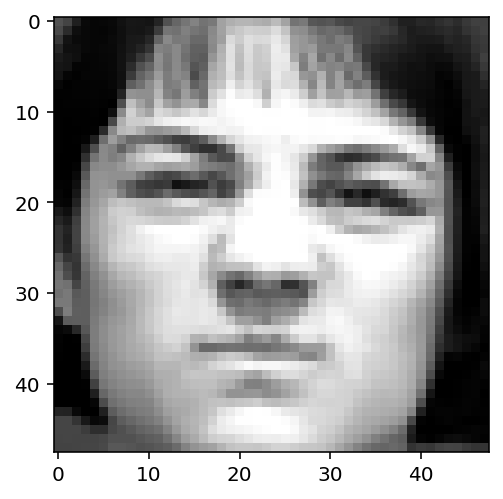

true val: disgusted , prediction: disgusted


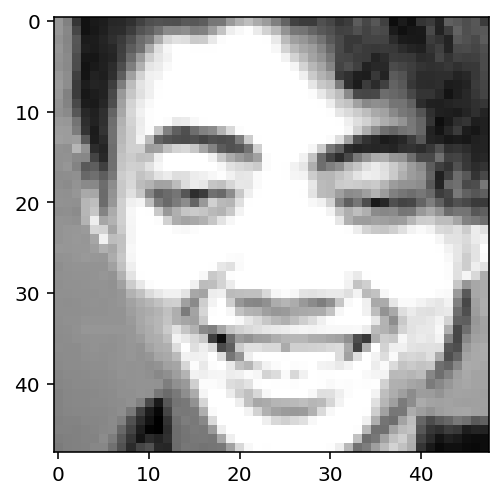

true val: happy , prediction: happy


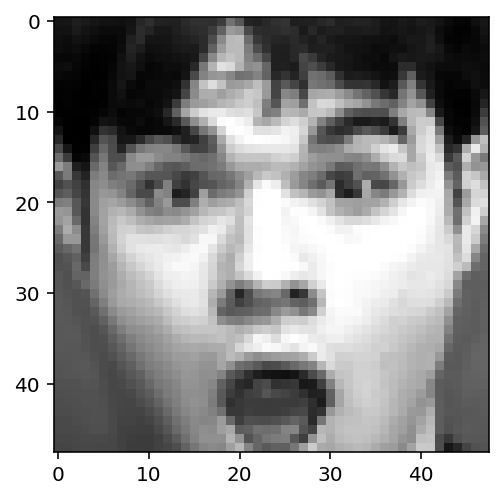

true val: surprised , prediction: surprised


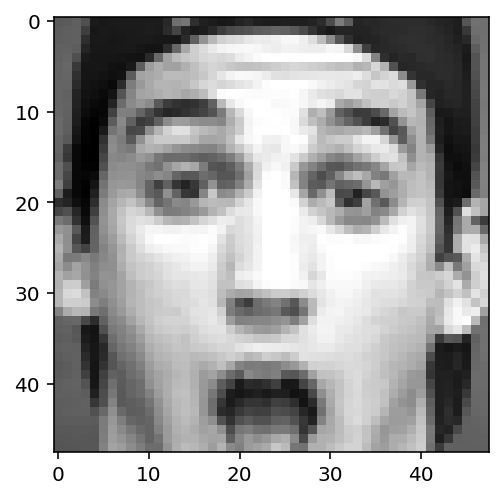

true val: surprised , prediction: surprised


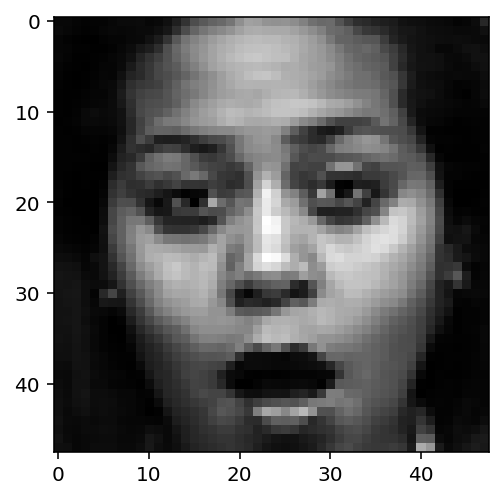

true val: surprised , prediction: surprised


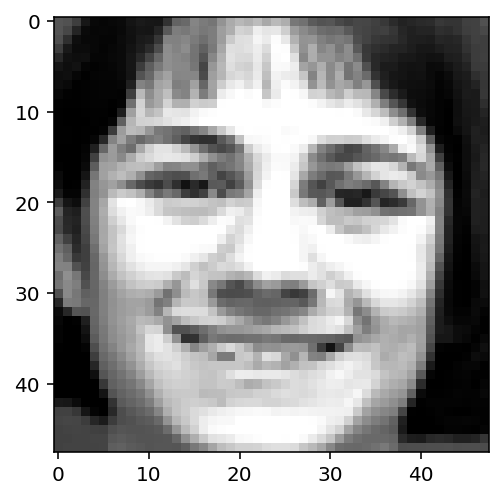

true val: happy , prediction: happy


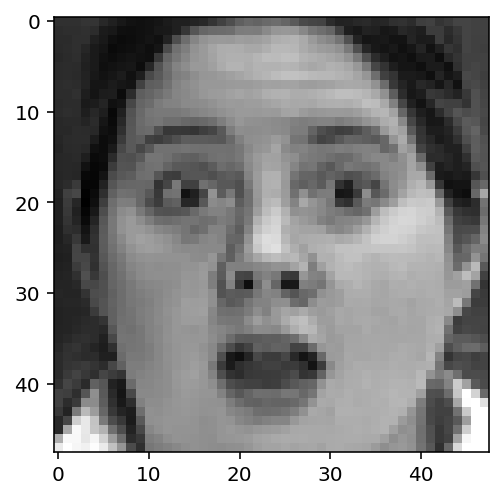

true val: surprised , prediction: surprised


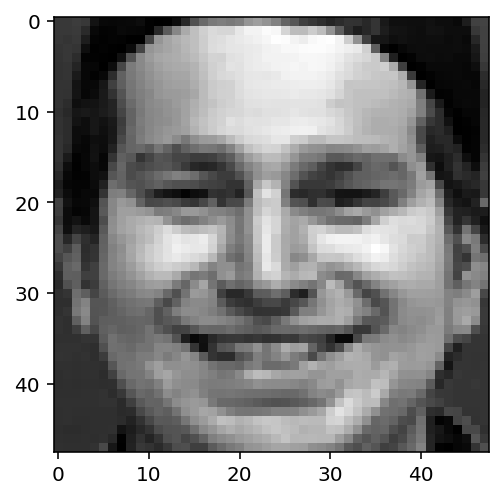

true val: happy , prediction: happy


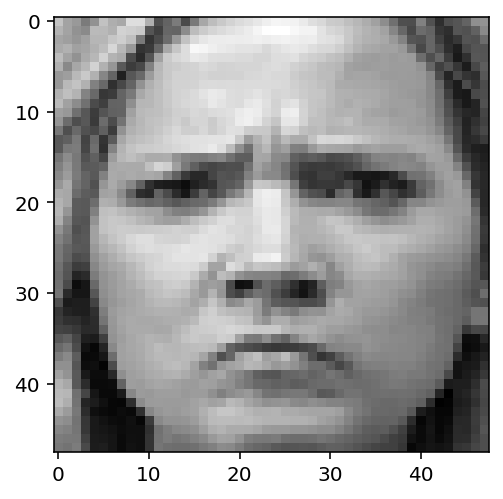

true val: angry , prediction: sad


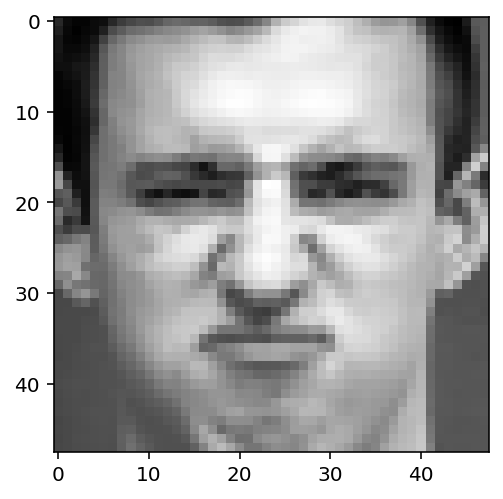

true val: disgusted , prediction: disgusted


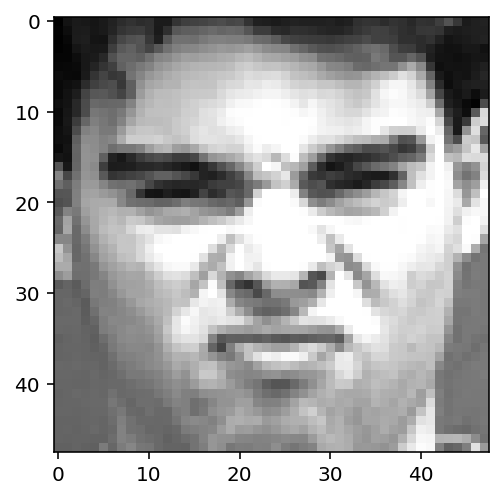

true val: disgusted , prediction: disgusted


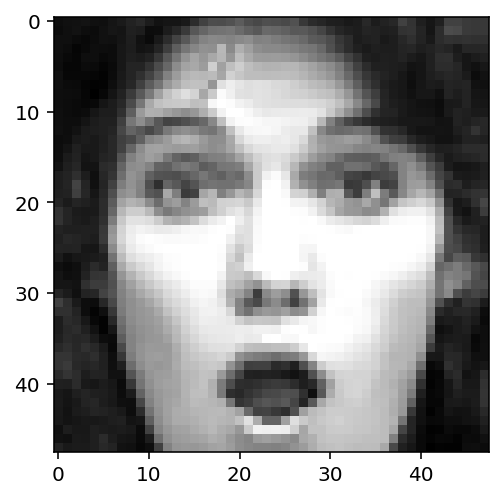

true val: surprised , prediction: surprised


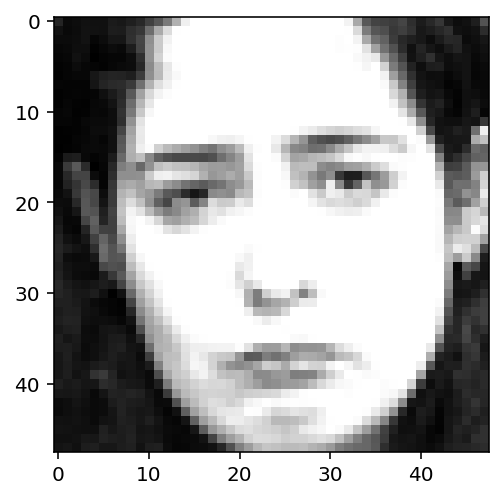

true val: sad , prediction: sad


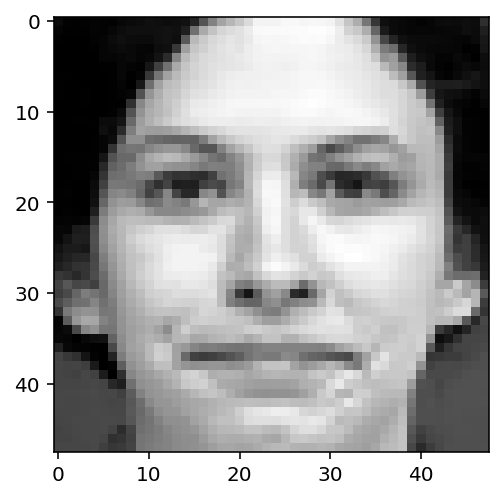

true val: neutral , prediction: afraid


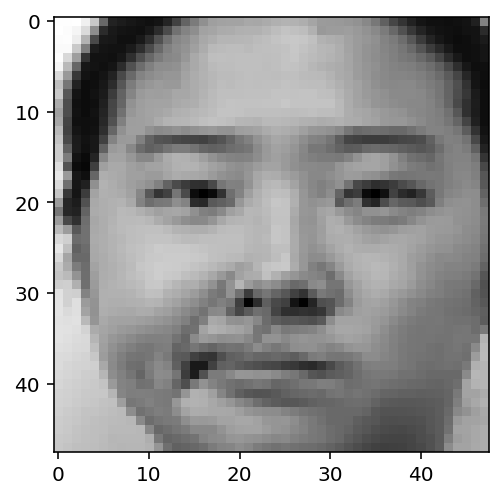

true val: neutral , prediction: neutral


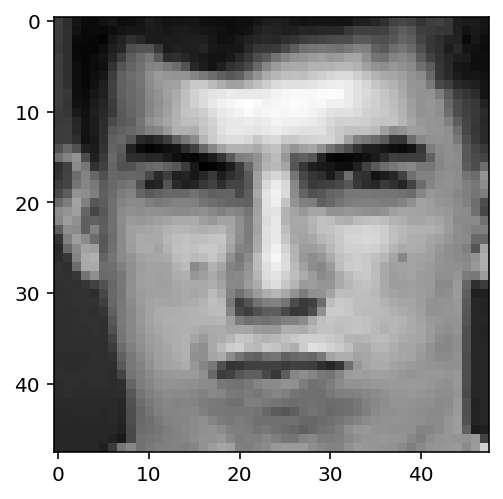

true val: angry , prediction: angry


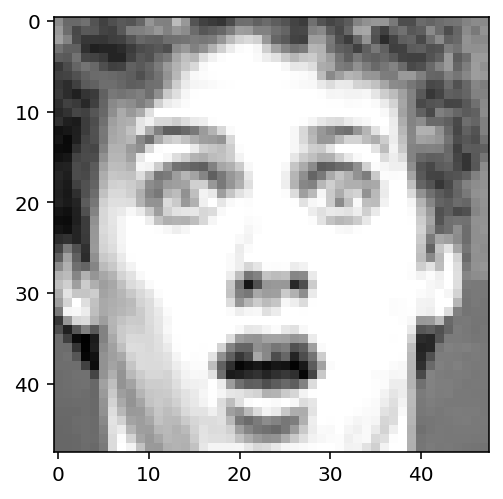

true val: surprised , prediction: surprised


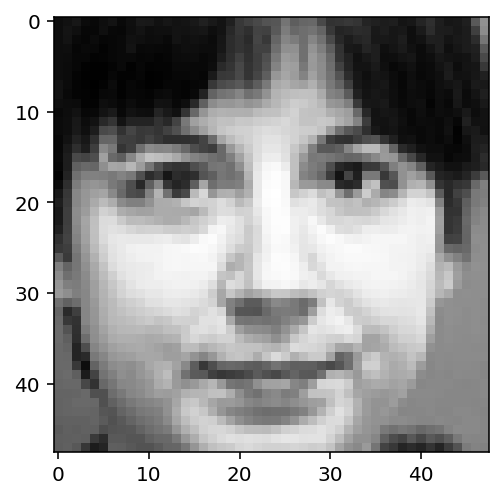

true val: neutral , prediction: neutral


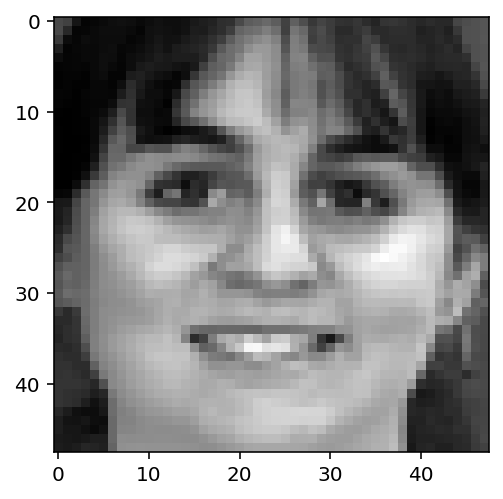

true val: happy , prediction: happy


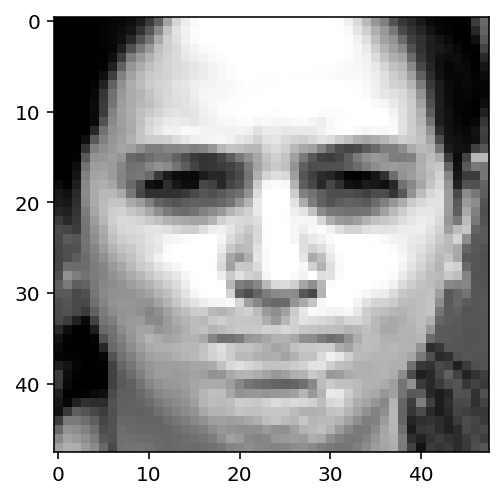

true val: angry , prediction: angry


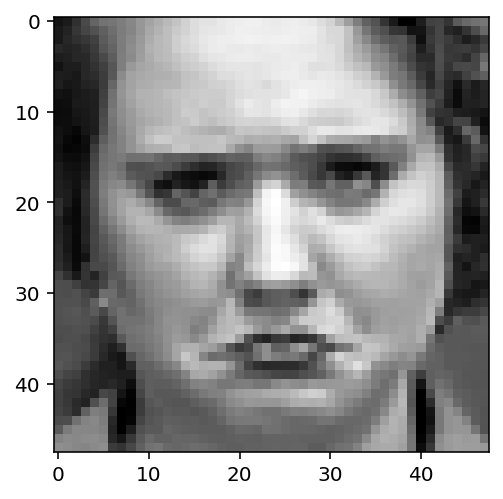

true val: sad , prediction: sad


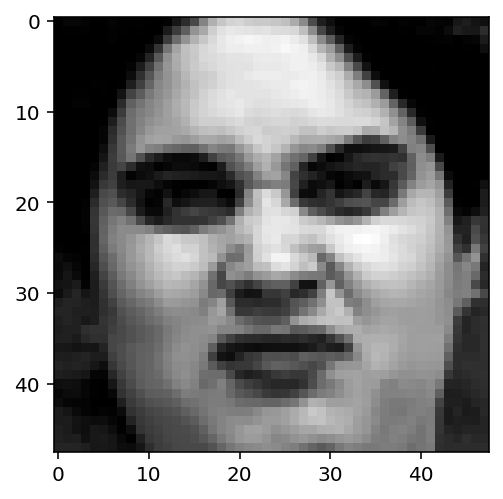

true val: disgusted , prediction: disgusted


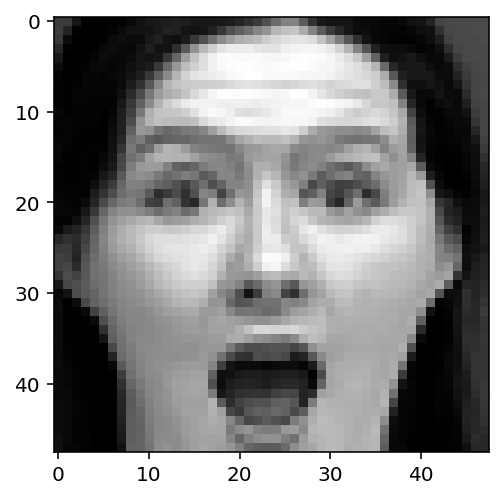

true val: surprised , prediction: surprised


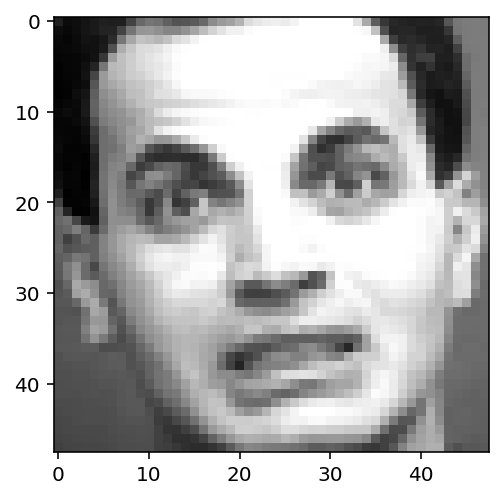

true val: afraid , prediction: afraid


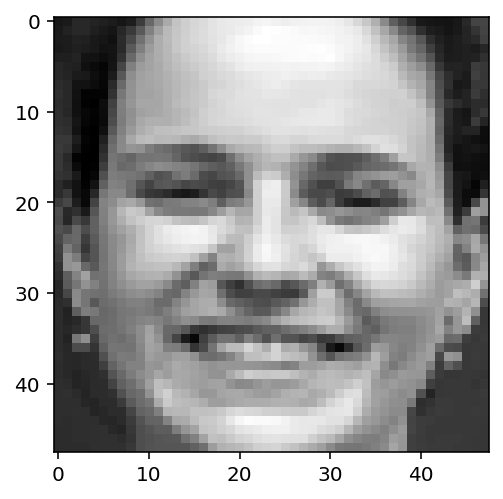

true val: happy , prediction: happy


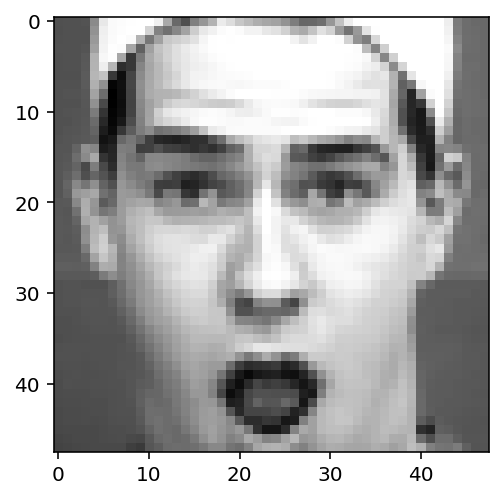

true val: surprised , prediction: surprised


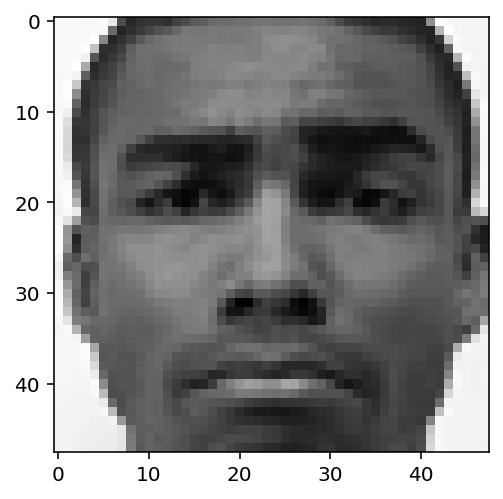

true val: sad , prediction: neutral


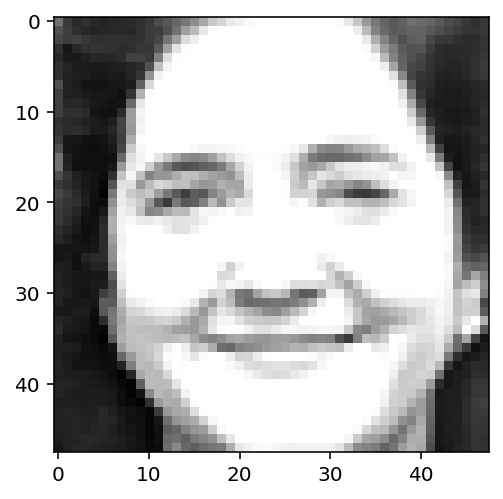

true val: happy , prediction: happy


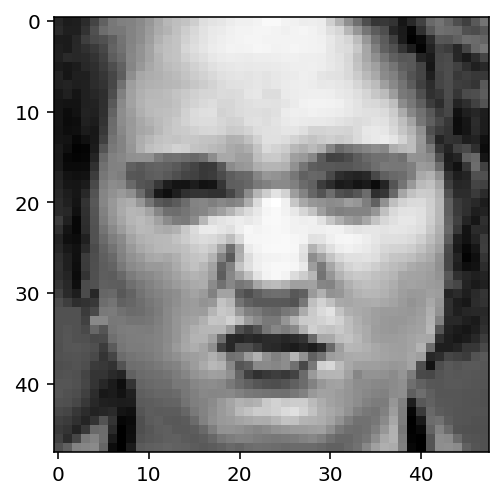

true val: disgusted , prediction: disgusted


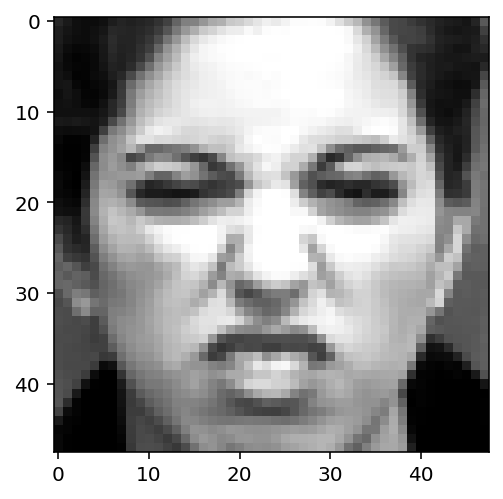

true val: disgusted , prediction: disgusted


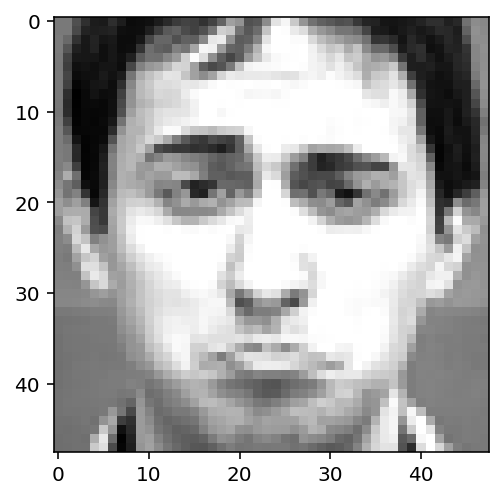

true val: sad , prediction: sad


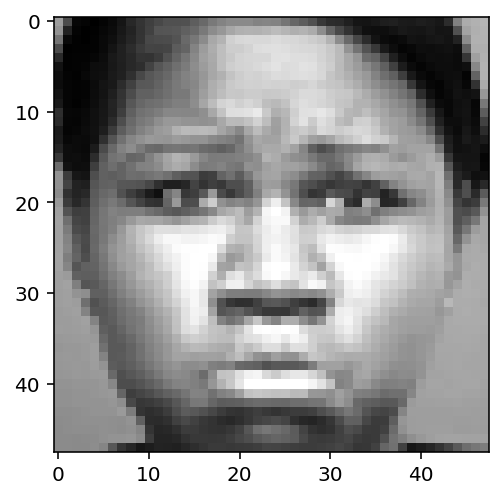

true val: sad , prediction: sad


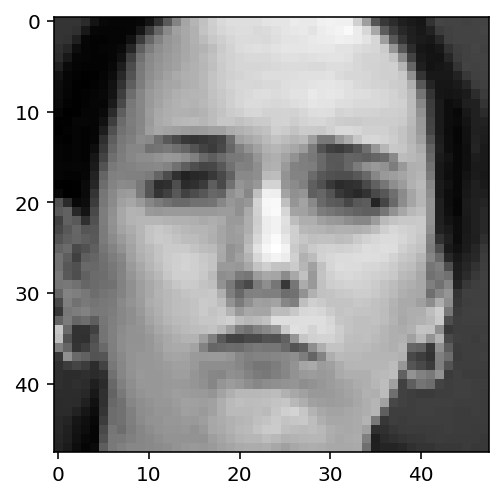

true val: sad , prediction: sad


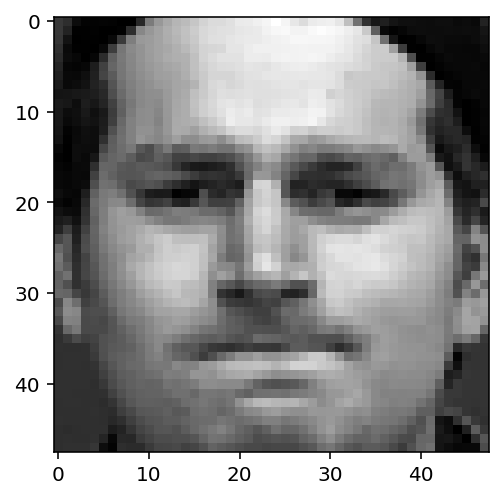

true val: angry , prediction: angry


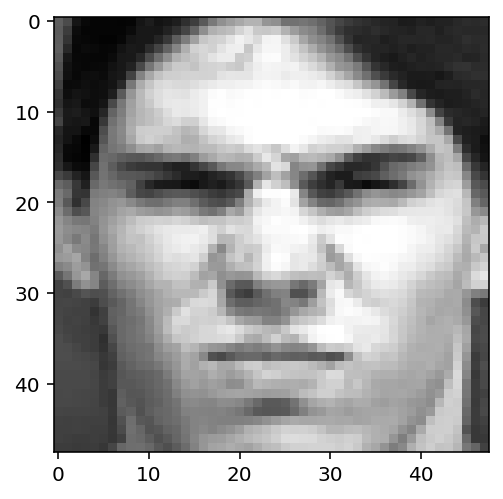

true val: disgusted , prediction: disgusted


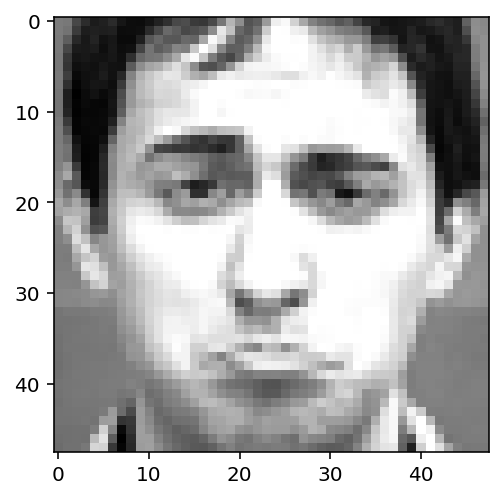

true val: sad , prediction: sad


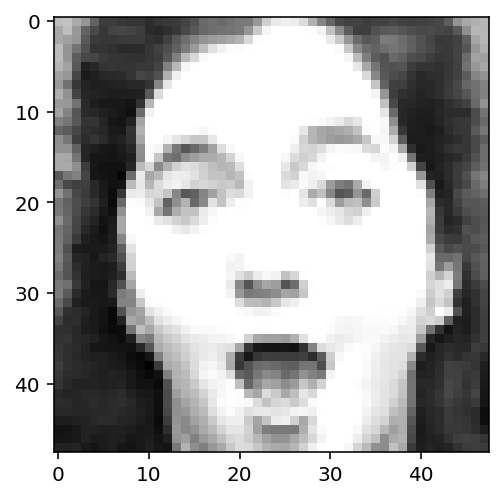

true val: surprised , prediction: surprised


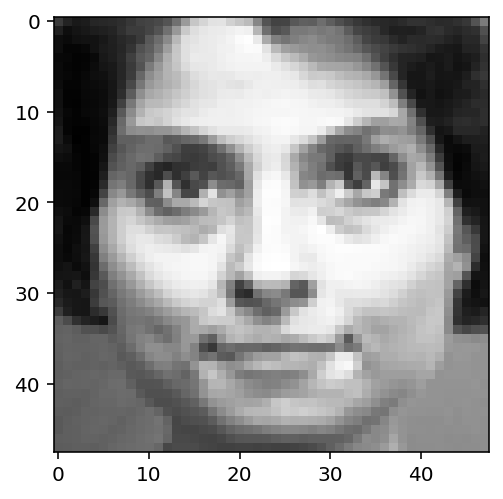

true val: neutral , prediction: neutral


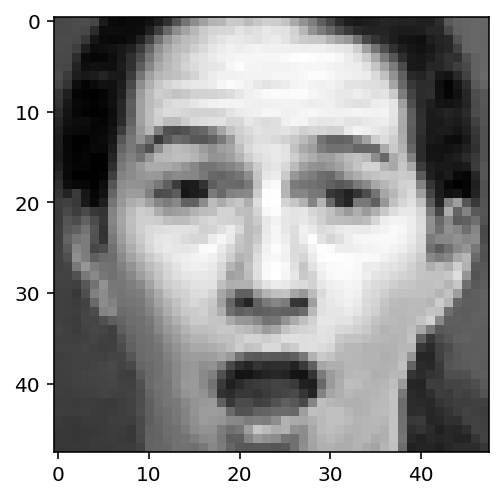

true val: surprised , prediction: surprised


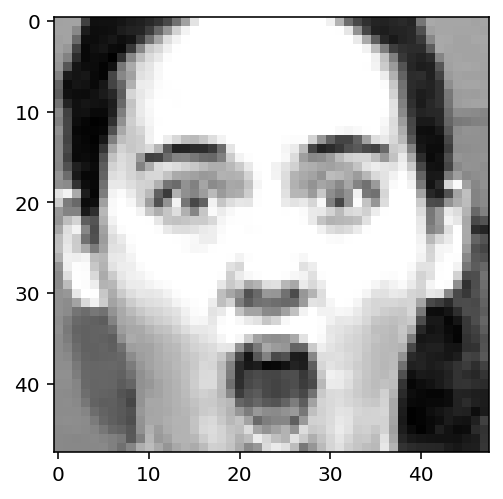

true val: surprised , prediction: surprised


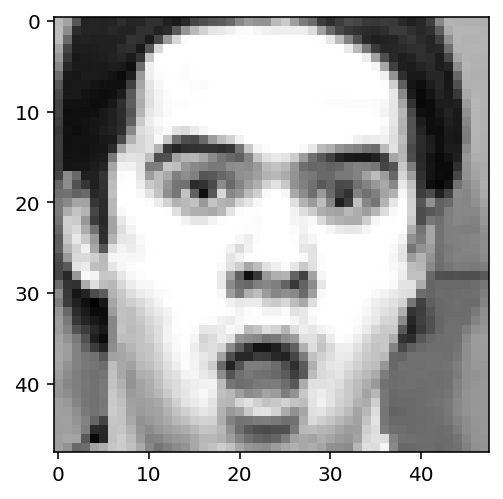

true val: surprised , prediction: surprised


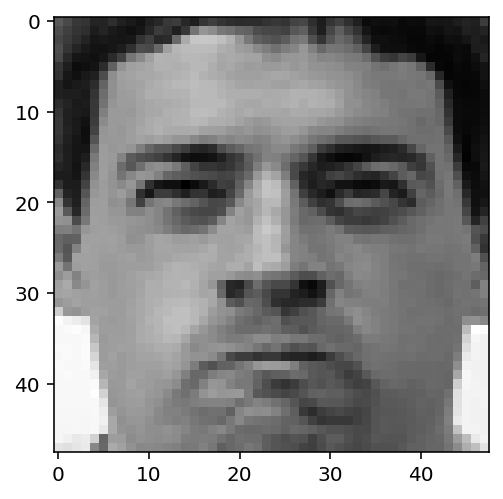

true val: angry , prediction: angry


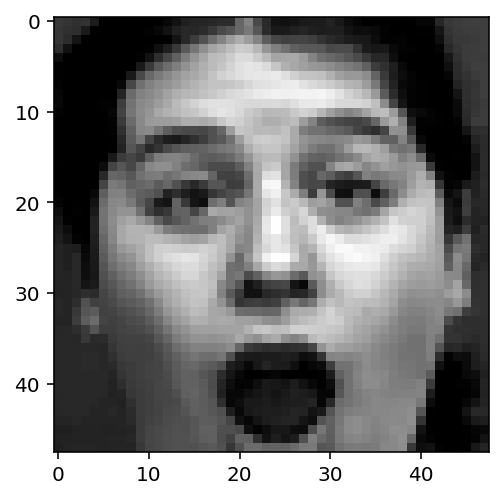

true val: surprised , prediction: surprised


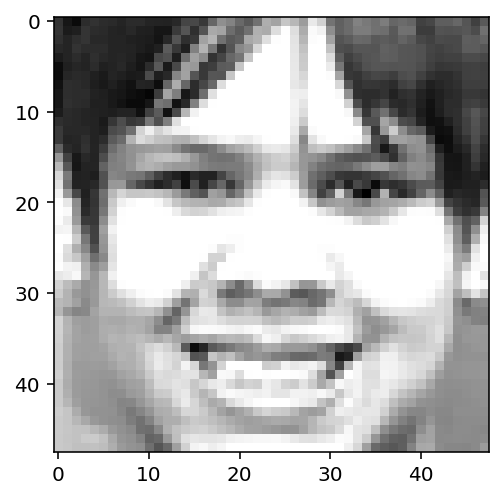

true val: happy , prediction: happy


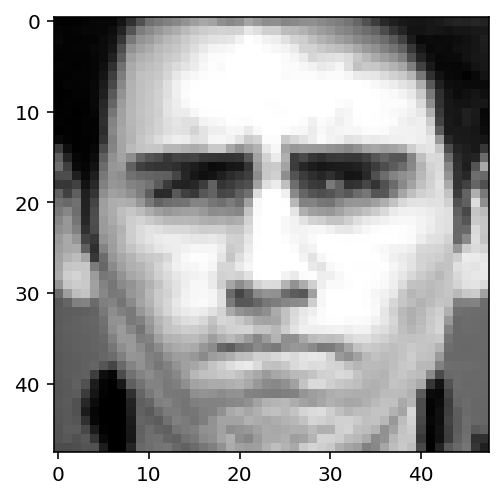

true val: angry , prediction: angry


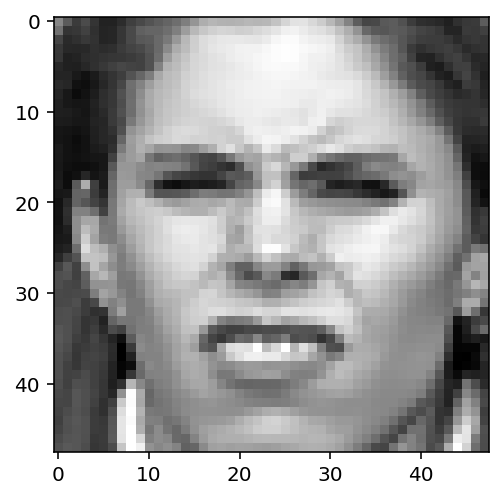

true val: disgusted , prediction: disgusted


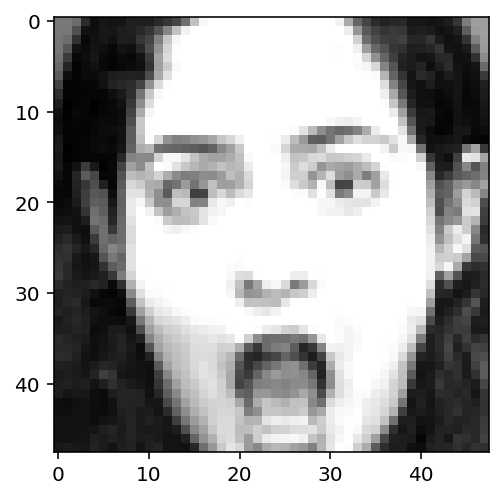

true val: surprised , prediction: surprised


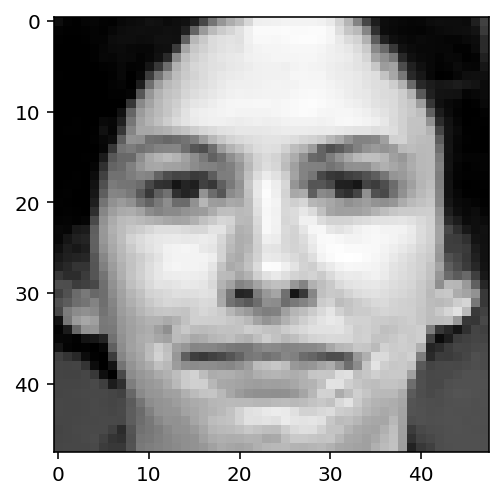

true val: neutral , prediction: afraid


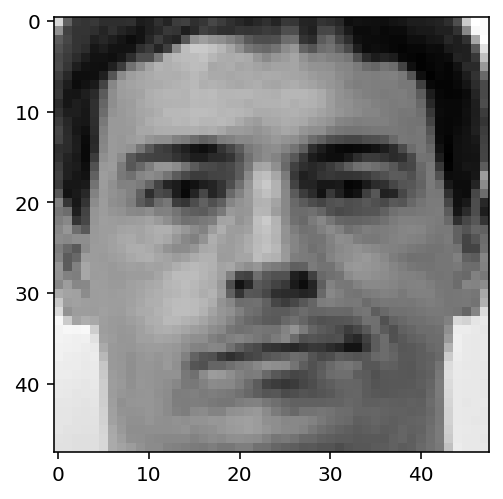

true val: neutral , prediction: neutral


In [44]:
classes = {0: "angry", 1: "disgusted", 2: "afraid", 3: "happy", 4: "neutral", 5: "sad", 6: "surprised"}

pred = model.predict_classes(x_test)

for i in range(len(pred)):
    plt.imshow(x_test[i], cmap="gray")
    plt.show()
    print("true val:", classes[np.argmax(y_test[i])], ", prediction:", classes[pred[i]])

In [45]:
# Save the model."
tf.saved_model.save(model, "./")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./assets


In [4]:
# Convert the model
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("./") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('compressed_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [15]:
print(x_test[0].shape)

(48, 48, 1)
